In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from transformers import BertTokenizer

In [2]:
#!conda install catboost -y

In [3]:
df=pd.read_excel('dataset_filledsupplier_currency_orderday.xlsx')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24621 entries, 0 to 24620
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   청구서번호        24621 non-null  object 
 1   No.          24621 non-null  int64  
 2   Subject      24599 non-null  object 
 3   Machinery    24621 non-null  object 
 4   Assembly     24621 non-null  object 
 5   청구품목         24621 non-null  object 
 6   Unnamed: 6   0 non-null      float64
 7   Part No.1    24602 non-null  object 
 8   Part No.2    3592 non-null   object 
 9   청구량          24517 non-null  float64
 10  견적           24171 non-null  object 
 11  견적수량         24517 non-null  float64
 12  견적화폐         24621 non-null  object 
 13  견적단가         24621 non-null  float64
 14  발주번호         24621 non-null  object 
 15  발주처          24621 non-null  object 
 16  발주           24621 non-null  object 
 17  발주수량         24621 non-null  int64  
 18  발주금액         24621 non-null  float64
 19  D/T 

In [5]:
print(len(df['발주처'].unique()))

81


## 클리닝

In [6]:
missing_conditions = df[
    df['발주'].notnull() &  # 발주 일자는 비어있지 않음
    df['미입고 기간'].isnull() &  # 미입고 기간은 비어있음
    df['창고입고'].isnull() & # 창고 입고도 비어있음
    df['선박입고'].isnull()  # 선박 입고도 비어있음

]

print(f"발주 일자는 있지만 미입고 기간, 창고 입고, 선박 입고도 없는 경우: {len(missing_conditions)}개")
df = df.drop(missing_conditions.index)

print(f"삭제된 행의 개수: {len(missing_conditions)}개")
print(f"남은 데이터프레임의 크기: {df.shape}")

발주 일자는 있지만 미입고 기간, 창고 입고, 선박 입고도 없는 경우: 1699개
삭제된 행의 개수: 1699개
남은 데이터프레임의 크기: (22922, 32)


In [7]:
#미입고기간으로 처리.
missing_both = df[df['창고입고'].isnull() & df['미입고 기간'].notnull()]

print(f"창고 입고일은 없고 미입고 기간은 명시되어 있어 미입고 기간으로 분류해야 할 경우 : {len(missing_both)}개")

창고 입고일은 없고 미입고 기간은 명시되어 있어 미입고 기간으로 분류해야 할 경우 : 1620개


In [8]:
df = df[df['미입고 기간'].isnull()]

df['발주'] = pd.to_datetime(df['발주'], errors='coerce')
df['창고입고'] = pd.to_datetime(df['창고입고'], errors='coerce')

# 리드타임 계산
df['리드타임'] = (df['창고입고'] - df['발주']).dt.days
df['리드타임'] = df['리드타임'].apply(lambda x: 1 if x == 0 else x)

In [9]:

df = df[(df['리드타임'] > 1 ) & (df['리드타임'] < 200)]
df = df.dropna(subset=['창고입고'])

In [10]:
print(df[['발주', '창고입고']].head(), df['창고입고'].isnull().sum())

          발주       창고입고
0 2019-01-11 2019-05-03
1 2019-01-11 2019-04-18
2 2019-01-11 2019-05-03
5 2019-06-03 2019-06-15
6 2019-06-03 2019-06-15 0


In [180]:
print(df.columns)
df['리드타임'] = df['리드타임'].astype(float)  # 필요시 데이터 타입 변환


Index(['청구서번호', 'No.', 'Subject', 'Machinery', 'Assembly', '청구품목',
       'Unnamed: 6', 'Part No.1', 'Part No.2', '청구량', '견적', '견적수량', '견적화폐',
       '견적단가', '발주번호', '발주처', '발주', '발주수량', '발주금액', 'D/T', '미입고 기간', '창고입고',
       '창고입고수량', 'Control No.', '입고창고', '창고출고', '창고출고수량', '출고선박', '출고운반선',
       '선박입고', '선박입고수량', '완료 여부', '리드타임'],
      dtype='object')


### 날짜뽑기

> 연도는 숫자형으로 처리(새로운 연도에 대응)
> 나머지는 원핫인코딩

In [11]:
# 월(month), 요일(day of the week) 추출
df['month'] = df['창고입고'].dt.month
df['day_of_week'] = df['창고입고'].dt.dayofweek
df['year'] = df['창고입고'].dt.year

def get_season(date):
    month = date.month
    if month in [3, 4, 5]:
        return '봄'
    elif month in [6, 7, 8]:
        return '여름'
    elif month in [9, 10, 11]:
        return '가을'
    else:
        return '겨울'

df['season'] = df['창고입고'].apply(get_season)

df = pd.get_dummies(df, columns=['month', 'day_of_week', 'season'], drop_first=True)


In [12]:
import re

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\([^)]*\)', '', text)
    text = re.sub(r'[^\w\s\*/\-\+.,#&]', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\b(사용금지|사)\b', '', text, flags=re.IGNORECASE)
    text = text.strip()
    return text

def clean_supplier_name(name):
    name = name.lower()
    name = re.sub(r'coporation|coropration|coproration|corporration', 'corporation', name)
    name = re.sub(r'\(사용금지\)', '', name)
    name = re.sub(r'u\.s\.a', '_usa', name)
    name = re.sub(r'\.', '', name)
    suffixes = r'(corporation|corp|company|co|incorporated|inc|limited|ltd|상사|공사|엔지니어링|주식회사|주|gmbh|pte ltd|llc)'
    name = re.sub(suffixes, '', name, flags=re.IGNORECASE)
    name = re.sub(r'[^\w\s-]', '', name)
    name = re.sub(r'\s+', ' ', name).strip()
    return name



In [13]:

text_columns = ['Machinery', 'Assembly', '청구품목']

for col in text_columns:
    df[col] = df[col].astype(str)
df['cleaned_machinery'] = df['Machinery'].apply(preprocess_text)
df['cleaned_assembly'] = df['Assembly'].apply(preprocess_text)
df['cleaned_item'] = df['청구품목'].apply(preprocess_text)
df['cleaned_supplier'] = df['발주처'].apply(clean_supplier_name)

In [14]:
# Machinery별 평균 리드타임 계산
machinery_avg_leadtime = df.groupby('cleaned_machinery')['리드타임'].mean().reset_index()
machinery_avg_leadtime.rename(columns={'리드타임': 'machinery_avg_leadtime'}, inplace=True)

# 데이터프레임에 평균 리드타임 추가
df = df.merge(machinery_avg_leadtime, on='cleaned_machinery', how='left')

In [15]:
# Machinery & Assembly 조합별 평균 리드타임 계산
df['machinery_assembly'] = df['cleaned_machinery'] + " & " + df['cleaned_assembly']
assembly_machinery_avg_leadtime = df.groupby('machinery_assembly')['리드타임'].mean().reset_index()
assembly_machinery_avg_leadtime.rename(columns={'리드타임': 'machinery_assembly_avg_leadtime'}, inplace=True)

# 데이터프레임에 Machinery & Assembly 조합의 평균 리드타임 추가
df = df.merge(assembly_machinery_avg_leadtime, on='machinery_assembly', how='left')


In [16]:
# 발주처별 평균 리드타임 계산 (cleaned_supplier 사용)
# supplier_leadtime_avg = df.groupby('cleaned_supplier')['리드타임'].mean().reset_index()
#supplier_leadtime_avg.rename(columns={'리드타임': 'supplier_avg_leadtime'}, inplace=True)

# 원본 데이터프레임에 발주처별 평균 리드타임 추가 (cleaned_supplier로 병합)
# df = df.merge(supplier_leadtime_avg, on='cleaned_supplier', how='left')


In [17]:
# 발주처별 + Machinery 조합별 평균 리드타임 계산
supplier_machinery_leadtime = df.groupby(['cleaned_supplier', 'cleaned_machinery'])['리드타임'].mean().reset_index()
supplier_machinery_leadtime.rename(columns={'리드타임': 'supplier_machinery_avg_leadtime'}, inplace=True)

# 원본 데이터프레임에 병합
df = df.merge(supplier_machinery_leadtime, on=['cleaned_supplier', 'cleaned_machinery'], how='left')

In [192]:
df[['Machinery','Assembly','리드타임', '발주처', 'machinery_avg_leadtime','machinery_assembly_avg_leadtime', 'supplier_avg_leadtime', 'supplier_machinery_avg_leadtime']].head(20)

,Machinery,Assembly,리드타임,발주처,machinery_avg_leadtime,machinery_assembly_avg_leadtime,supplier_avg_leadtime,supplier_machinery_avg_leadtime
0,CARGO BOOM VANG BLOCK (STBD 하),BLOCK,112.0,MATSUI(U.S.A) COROPRATION,98.333333,102.000000,90.609616,98.333333
1,SPANISH BOOM VANG BLOCK (PORT 상),BLOCK,97.0,MATSUI(U.S.A) COROPRATION,72.000000,63.750000,90.609616,121.000000
2,PURSE BLOCK,TOW BLOCK,112.0,MATSUI(U.S.A) COROPRATION,100.000000,91.333333,90.609616,97.666667
3,NET,H-EX,12.0,KTI,16.627119,16.642857,18.484472,16.675926
4,NET,NYLON,12.0,KTI,16.627119,12.190476,18.484472,16.675926
5,NET,NYLON,12.0,KTI,16.627119,12.190476,18.484472,16.675926
6,NET,NYLON,12.0,KTI,16.627119,12.190476,18.484472,16.675926
7,NET,NYLON,12.0,KTI,16.627119,12.190476,18.484472,16.675926
8,NET,NYLON,12.0,KTI,16.627119,12.190476,18.484472,16.675926
9,NET,H-EX,12.0,KTI,16.627119,16.642857,18.484472,16.675926


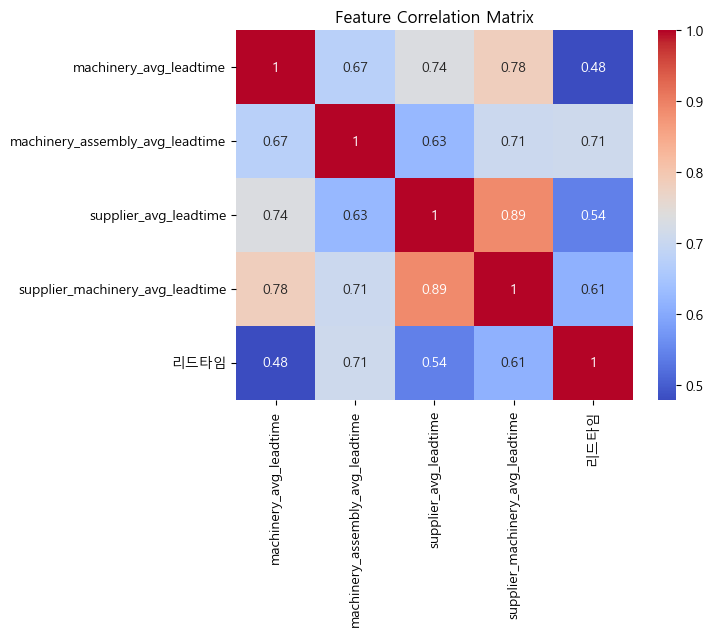

In [159]:
import seaborn as sns
import matplotlib.pyplot as plt

# 피처 간 상관관계 계산 및 시각화
correlation_matrix = df[['machinery_avg_leadtime', 'machinery_assembly_avg_leadtime', 
                         'supplier_avg_leadtime', 'supplier_machinery_avg_leadtime', '리드타임']].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

In [40]:
fixed_columns = [
    'cleaned_machinery', 'cleaned_assembly', '청구품목',  'cleaned_supplier', '리드타임',
    'machinery_avg_leadtime', 'machinery_assembly_avg_leadtime',  
    'supplier_avg_leadtime', '견적화폐'
]

# 해당 컬럼들만 선택하여 새로운 데이터프레임 생성
df_fixed = df[fixed_columns]

# 고정 피처들을 CSV로 저장
df_fixed.to_csv('leadtime_features.csv', index=False)

print("고정 피처가 포함된 CSV 파일이 저장되었습니다.")

고정 피처가 포함된 CSV 파일이 저장되었습니다.


In [41]:
past_columns = [
    'Machinery', 'Assembly', '청구품목', 'Part No.1', '견적화폐', '견적단가', '발주처', '발주', '창고입고', '리드타임'
]

# 해당 컬럼들만 선택하여 새로운 데이터프레임 생성
df_past = df[past_columns]

# 고정 피처들을 CSV로 저장
df_past.to_csv('past_leadtime.csv', index=False)

print("과거 리드타임 포함된 CSV 파일이 저장되었습니다.")

과거 리드타임 포함된 CSV 파일이 저장되었습니다.


### 리드타임 예측 (회귀)
1. 텍스트 칼럼 결합 word2vec
2. ( 수치형 데이터(견적단가 및 발주량) Scaling )
3. 범주형 데이터(견적화폐) onehotEncoding
4. 모델의 입력, 2.3데이터 결합 => 리드타임 예측

In [18]:
from gensim.models import Word2Vec

# 데이터 전처리 후 토큰화 (문장을 단어 리스트로 변환)
machinery_sentences = [text.split() for text in df['cleaned_machinery']]
assembly_sentences = [text.split() for text in df['cleaned_assembly']]

# 각각의 Word2Vec 모델 학습
word2vec_machinery = Word2Vec(sentences=machinery_sentences, vector_size=100, window=5, min_count=1, workers=4)
word2vec_assembly = Word2Vec(sentences=assembly_sentences, vector_size=100, window=5, min_count=1, workers=4)

# 각 텍스트에 대한 벡터 평균값 계산 (문장 단위로 벡터를 평균화하여 문장 벡터 생성)
def sentence_vector(sentence, model):
    vectors = [model.wv[word] for word in sentence if word in model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# 각 컬럼별로 벡터화
machinery_vectors = np.array([sentence_vector(sentence, word2vec_machinery) for sentence in machinery_sentences])
assembly_vectors = np.array([sentence_vector(sentence, word2vec_assembly) for sentence in assembly_sentences])

# 결과 확인
print(f"Word2Vec Machinery Shape: {machinery_vectors.shape}")
print(f"Word2Vec Assembly Shape: {assembly_vectors.shape}")


Word2Vec Machinery Shape: (19330, 100)
Word2Vec Assembly Shape: (19330, 100)


In [64]:
# Word2Vec 모델 저장 (Gensim 방식)
word2vec_machinery.save('word2vec_machinery.model')
word2vec_assembly.save('word2vec_assembly.model')

In [65]:
#!conda install conda-forge::category_encoders -y

In [19]:
from sklearn.preprocessing import MinMaxScaler

# 1. 수치형 피처 스케일링
scaler = MinMaxScaler()

# 수치형 피처 (리드타임 관련 피처들) 스케일링
numerical_features = df[['machinery_avg_leadtime', 'machinery_assembly_avg_leadtime', 'supplier_machinery_avg_leadtime']].values
scaled_numerical_features = scaler.fit_transform(numerical_features)

print(scaled_numerical_features)


[[0.69184716 0.52083333 0.52930403]
 [0.49709456 0.32161458 0.65384615]
 [0.70417327 0.46527778 0.52564103]
 ...
 [0.61130185 0.65530303 0.48386764]
 [0.61130185 0.65530303 0.48386764]
 [0.61130185 0.65530303 0.48386764]]


In [21]:
scaled_numerical_features[:, 1] = scaled_numerical_features[:, 1] * 2  # 'machinery_assembly_avg_leadtime'에 가중치 부여


In [25]:
from sklearn.preprocessing import OneHotEncoder

# 3. 견적화폐 One-Hot-Encoding
currency_ohe = OneHotEncoder(sparse_output=False)
currency_encoded = currency_ohe.fit_transform(df[['견적화폐']])

# currency_encoded 배열의 크기 확인
print(f"Shape of currency_encoded: {currency_encoded.shape}")

Shape of currency_encoded: (19330, 4)


### 데이터 분할


In [26]:
month_features = df.filter(like='month_').values
day_of_week_features = df.filter(like='day_of_week_').values
#year_features = df.filter(like='year_').values
season_features = df.filter(like='season_').values
year = df['year'].values.reshape(-1, 1)  # 숫자형 year 피처


In [27]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
import numpy as np
from scipy.sparse import hstack

# word2vec_machinery와 word2vec_assembly의 차원 확인
print(f"Shape of word2vec_machinery: {machinery_vectors.shape}")
print(f"Shape of word2vec_assembly: {assembly_vectors.shape}")

# Word2Vec 임베딩 배열 차원 수정
# (19330, 100) 형태의 배열 두 개를 가로로 결합하여 (19330, 200) 형태로 만들기
word2vec_combined = np.hstack((machinery_vectors, assembly_vectors))

# 크기 확인
print(f"Shape of word2vec_combined: {word2vec_combined.shape}")

# 모든 배열의 첫 번째 차원 (행 수)이 일치하는지 확인 후 결합
if word2vec_combined.shape[0] == scaled_numerical_features.shape[0]:
    # 모든 피처 결합 (수치형 + 요일/계절 OHE + 견적화폐 OHE + Word2Vec 임베딩)
    X = np.hstack((
        scaled_numerical_features,  # 스케일링된 수치형 피처들
        month_features,  # 월 One-Hot-Encoding 피처
        day_of_week_features,  # 요일 One-Hot-Encoding 피처
        year,  # 연도 숫자
        season_features,  # 계절 One-Hot-Encoding 피처
        currency_encoded,  # 견적화폐 One-Hot-Encoding 피처
        word2vec_combined  # Word2Vec 임베딩 피처들
    ))
    
    print(f"Shape of X: {X.shape}")
    

Shape of word2vec_machinery: (19330, 100)
Shape of word2vec_assembly: (19330, 100)
Shape of word2vec_combined: (19330, 200)
Shape of X: (19330, 228)


In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
y = df['리드타임'].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.15, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



In [29]:
print(f"X_train shape: {X_train.shape}")
print(f"X_train shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (16430, 228)
X_train shape: (1450, 228)
X_test shape: (1450, 228)
y_train shape: (16430,)
y_test shape: (1450,)
y_test shape: (1450,)


In [30]:
import lightgbm as lgb
from lightgbm import callback
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model_lgb = lgb.LGBMRegressor(
    objective='regression',
    metric='mae',  # MAE 사용
    learning_rate=0.05,  # 학습 속도 더 느리게
    num_leaves=30,  # 리프 개수 줄이기
    max_depth=8,  # 트리 깊이 줄이기
    n_estimators=6000,  # 트리 개수
    subsample=0.8,  # 데이터 샘플링 비율 조정
    colsample_bytree=0.7,  # 피처 샘플링 비율 조정
    reg_alpha=0.1,  # L1 규제 (정규화)
    reg_lambda=0.1  # L2 규제 (정규화)
)

# 콜백 설정
callbacks = [
    callback.early_stopping(stopping_rounds=50),  # 개선 없으면 학습 중단
    callback.log_evaluation(period=1000)  # 1000 라운드마다 로그 표시
]

# 모델 학습
model_lgb.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],  # 검증 데이터 추가
    eval_metric='mae',
    callbacks=callbacks
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37687
[LightGBM] [Info] Number of data points in the train set: 16430, number of used features: 228
[LightGBM] [Info] Start training from score 69.323068
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1000]	valid_0's l1: 9.15561
[LightGBM] [Warning] No further splits w

LGBMRegressor(colsample_bytree=0.7, learning_rate=0.05, max_depth=8,
              metric='mae', n_estimators=6000, num_leaves=30,
              objective='regression', reg_alpha=0.1, reg_lambda=0.1,
              subsample=0.8)

In [31]:

# 테스트 데이터로 최종 성능 평가
y_pred = model_lgb.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R^2 Score: {r2}")

Mean Absolute Error (MAE): 5.402290372823216
Root Mean Squared Error (RMSE): 15.153656625990125
Mean Squared Error (MSE): 229.63330913841443
R^2 Score: 0.9153701844128428


In [33]:
import pickle

# 학습 완료된 LightGBM 모델 저장
with open('leadtime_model.pkl', 'wb') as f:
    pickle.dump(model_lgb, f)